In [1]:

from __future__ import print_function

import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, SpatialDropout1D, Dropout, BatchNormalization, LSTM
from keras.models import Model
import pandas as pd
from matplotlib import pylab as plt
import tensorflow as tf
%matplotlib inline

Using TensorFlow backend.


In [213]:
BASE_DIR = ''
GLOVE_DIR = BASE_DIR + ''
TEXT_DATA_DIR = BASE_DIR + 'data\\'
MAX_SEQUENCE_LENGTH = 1000
#MAX_NB_WORDS = 20000
MAX_NB_WORDS = 90000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2


In [214]:
# second, prepare text samples and their labels
data = pd.read_csv("vfeed.csv", sep="|")


C:\Users\aliex\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [215]:
#preparing a column data types
data['date_published'] = pd.to_datetime(data['date_published'])
data['date_modified'] = pd.to_datetime(data['date_modified'])
#data.replace(to_replace="not_defined", value=0, inplace=True)
#data.replace(to_replace="not_calculated", value=0, inplace=True)
#data[['cvss_base', 'cvss_impact', 'cvss_exploit']]= data[['cvss_base', 'cvss_impact', 'cvss_exploit']].apply(pd.to_numeric)


In [216]:
data_sum_cvss = data[['summary','cvss_base','cvss_impact','cvss_exploit']]
data_sum_cvss = data_sum_cvss[(data_sum_cvss.cvss_base != "not_defined")    & 
                              (data_sum_cvss.cvss_exploit != "not_defined") &
                              (data_sum_cvss.cvss_impact != "not_defined")  & 
                              (data_sum_cvss.cvss_base != "not_calculated") & 
                              (data_sum_cvss.cvss_exploit != "not_calculated") & 
                              (data_sum_cvss.cvss_impact != "not_calculated")]
targets = data_sum_cvss[['cvss_base','cvss_impact','cvss_exploit']].apply(pd.to_numeric)
texts = data_sum_cvss[['summary']]

In [217]:
targets=targets[:MAX_NB_WORDS]
texts=texts[:MAX_NB_WORDS]

In [218]:

targets = targets[['cvss_base','cvss_impact','cvss_exploit']].apply(round)


In [219]:
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts['summary'])
sequences = tokenizer.texts_to_sequences(texts['summary'])


word_index = tokenizer.word_index
print('Found %s tokens.' % len(word_index))

pad_seq = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

Found 90042 tokens.


In [220]:
word_index

{'in': 1,
 'to': 2,
 'the': 3,
 'a': 4,
 'and': 5,
 '1': 6,
 'via': 7,
 'allows': 8,
 'remote': 9,
 'attackers': 10,
 '0': 11,
 '2': 12,
 'before': 13,
 'of': 14,
 'arbitrary': 15,
 'vulnerability': 16,
 '3': 17,
 'or': 18,
 'php': 19,
 '5': 20,
 'cve': 21,
 '4': 22,
 'x': 23,
 'execute': 24,
 '6': 25,
 'which': 26,
 'service': 27,
 'an': 28,
 'code': 29,
 'for': 30,
 'cause': 31,
 'denial': 32,
 '7': 33,
 'parameter': 34,
 'unspecified': 35,
 'users': 36,
 'web': 37,
 'crafted': 38,
 '8': 39,
 'vectors': 40,
 'by': 41,
 'file': 42,
 'is': 43,
 'site': 44,
 'not': 45,
 '10': 46,
 'allow': 47,
 'sql': 48,
 'server': 49,
 'earlier': 50,
 'on': 51,
 'that': 52,
 'information': 53,
 'with': 54,
 '9': 55,
 'cross': 56,
 'aka': 57,
 'local': 58,
 'as': 59,
 'html': 60,
 'script': 61,
 '2016': 62,
 'windows': 63,
 'scripting': 64,
 'xss': 65,
 'does': 66,
 '11': 67,
 'inject': 68,
 'application': 69,
 'memory': 70,
 'function': 71,
 'buffer': 72,
 'through': 73,
 'multiple': 74,
 '2015': 75,


In [221]:
#labels = to_categorical(np.asarray(targets['cvss_base']))
labels = np.asarray(targets['cvss_base'])
#labels_fname = np.asarray(labels_fname)
print('Objects:', pad_seq.shape)
print('Labels:', labels.shape)
#print('Labels_fname:', labels_fname.shape)


Objects: (90000, 1000)
Labels: (90000,)


In [222]:
def round_delimiter(arr, d):
    answ = []
    for x in arr:
        answ.append(1 if int(x) > d else 0)
    return answ

labels_5_not_cat = np.asarray(round_delimiter( labels, 5.1 ))

In [223]:
labels_5 = to_categorical(labels_5_not_cat)

In [224]:
#shuffle data
indices = np.arange(pad_seq.shape[0])
np.random.shuffle(indices)
pad_seq = pad_seq[indices]
labels = labels[indices]
labels_5 = labels_5[indices]
num_validation_samples = int(VALIDATION_SPLIT * pad_seq.shape[0])


In [225]:
# split the data into a training set and a validation set
x_train = pad_seq[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = pad_seq[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

y_train_5 = labels_5[:-num_validation_samples]
y_val_5 = labels_5[-num_validation_samples:]

#y_train = labels[:-num_validation_samples]


In [226]:
# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.50d.txt'), encoding="utf8")
#f = open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found  %s word vectors.' % len(embeddings_index))


Indexing word vectors.
Found  400000 word vectors.


In [227]:
print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:

        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Preparing embedding matrix.


In [228]:
def make_feature_vec(words, model, num_features):
    """
    Average the word vectors for a set of words
    """
    feature_vec = np.zeros((num_features,),dtype="float32")  # pre-initialize (for speed)
    nwords = 0.
    index2word_set = set(model.index2word)  # words known to the model

    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            feature_vec = np.add(feature_vec,model[word])
    
    feature_vec = np.divide(feature_vec, nwords)
    return feature_vec


def get_avg_feature_vecs(reviews, model, num_features):
    """
    Calculate average feature vectors for all reviews
    """
    counter = 0.
    review_feature_vecs = np.zeros((len(reviews),num_features), dtype='float32')  # pre-initialize (for speed)
    
    for review in reviews:
        review_feature_vecs[counter] = make_feature_vec(review, model, num_features)
        counter = counter + 1.
    return review_feature_vecs



In [229]:
# calculate average feature vectors for training and test sets
#clean_train_reviews = []
#for review in train_reviews['Text']:
#    clean_train_reviews.append(review_to_wordlist(review, remove_stopwords=True))

    
#trainDataVecs = get_avg_feature_vecs(clean_train_reviews, model, EMBEDDING_DIM)

x_train_average = np.zeros((x_train.shape[0], EMBEDDING_DIM))

sentence_i = 0
for sentenceVector in x_train:
    word_i = 0
    feature_vector = np.zeros((EMBEDDING_DIM,),dtype="float32")  # pre-initialize (for speed)
    for wordIndex in sentenceVector:
        if wordIndex > 0:
            embedding_vector = embedding_matrix[wordIndex]
            feature_vector = np.add(feature_vector, embedding_vector)
            word_i += 1
    
    feature_vector = np.divide(feature_vector, word_i)
    x_train_average[sentence_i] = feature_vector
    sentence_i += 1

#x_train_average.shape
x_test_average = np.zeros((x_val.shape[0], EMBEDDING_DIM))

sentence_i = 0
for sentenceVector in x_val:
    word_i = 0
    feature_vector = np.zeros((EMBEDDING_DIM,),dtype="float32")  # pre-initialize (for speed)
    for wordIndex in sentenceVector:
        if wordIndex > 0:
            embedding_vector = embedding_matrix[wordIndex]
            feature_vector = np.add(feature_vector, embedding_vector)
            word_i += 1
    
    feature_vector = np.divide(feature_vector, word_i)
    x_test_average[sentence_i] = feature_vector
    sentence_i += 1



In [230]:
x_train.shape[0]

72000

In [281]:
from sklearn.ensemble import RandomForestClassifier
# Fit a random forest to the training data, using 100 trees
forest = RandomForestClassifier(n_estimators = 1500)

print("Fitting a random forest to labeled training data...")
forest = forest.fit(x_train_average, y_train_5)


Fitting a random forest to labeled training data...


In [282]:
result = forest.predict(x_test_average)

In [283]:
# analyze results
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
print(classification_report(y_val_5, result))
print(forest.score(x_test_average, y_val_5))
x_test_average.shape

             precision    recall  f1-score   support

          0       0.78      0.76      0.77      8341
          1       0.80      0.82      0.81      9659

avg / total       0.79      0.79      0.79     18000

0.7926111111111112


(18000, 50)

In [234]:
probs = np.array(forest.predict_proba(x_test_average)[0])[:,1]
y_val_5_classes = np.array([x[0] for x in y_val_5])
print(probs.shape)
print(y_val_5_classes.shape)

fpr, tpr, _ = roc_curve(y_val_5_classes, probs)
auc = roc_auc_score(y_val_5_classes, probs)


(18000,)
(18000,)


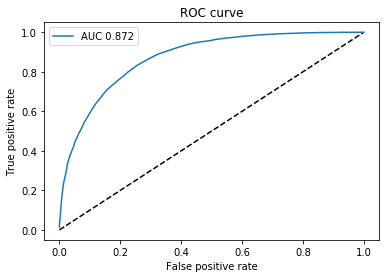

In [235]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [274]:
from sklearn.naive_bayes import MultinomialNB

y_train_5_classes = y_train_5[:,0]
x_train_average_positive = np.add(x_train_average, abs(np.min(x_train_average)))

naiveb = MultinomialNB()
print("Fitting a random forest to labeled training data...")
naiveb = naiveb.fit(x_train_average_positive, y_train_5_classes)

Fitting a random forest to labeled training data...


In [275]:
x_test_average_positive = np.add(x_test_average, abs(np.min(x_train_average)))

resultNB = naiveb.predict(x_test_average_positive)

In [276]:
y_val_5_classes_NB = y_val_5[:,0]

print(classification_report(y_val_5_classes_NB, resultNB))
print(naiveb.score(x_test_average_positive, y_val_5_classes_NB))

             precision    recall  f1-score   support

        0.0       0.54      1.00      0.70      9659
        1.0       0.00      0.00      0.00      8341

avg / total       0.29      0.54      0.37     18000

0.5366111111111111


C:\Users\aliex\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [277]:
probsNB = np.array(naiveb.predict_proba(x_test_average_positive))[:,1]

fprNB, tprNB, _ = roc_curve(y_val_5_classes_NB, probsNB)
aucNB = roc_auc_score(y_val_5_classes_NB, probsNB)


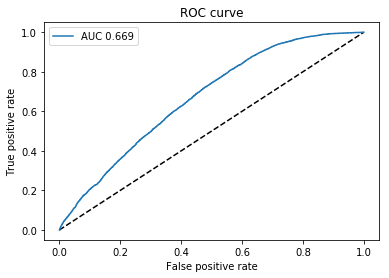

In [263]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fprNB, tprNB, label='AUC {:.3f}'.format(aucNB))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

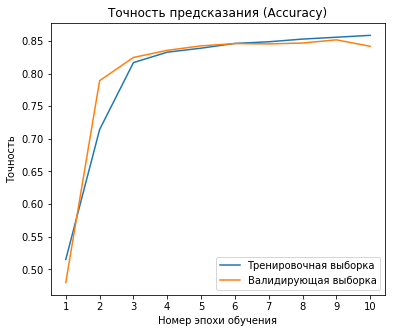

In [56]:
xticks = np.arange(1,11)

# Plot training & validation accuracy values
plt.figure(figsize=(6,5))
plt.plot(xticks, history.history['acc'])
plt.plot(xticks, history.history['val_acc'])
plt.title('Точность предсказания (Accuracy)')
plt.ylabel('Точность')
plt.xlabel('Номер эпохи обучения')
plt.xticks(xticks)
plt.legend(['Тренировочная выборка', 'Валидирующая выборка'], loc='best')
plt.show()

In [53]:
history.history['loss']

[0.7505089548275683,
 0.5419177857369357,
 0.4263418304568658,
 0.4000183467459465,
 0.3867106519761118,
 0.3759015588053532,
 0.36549049285350815,
 0.3586748909140462,
 0.353036738914085,
 0.34708724496175014]

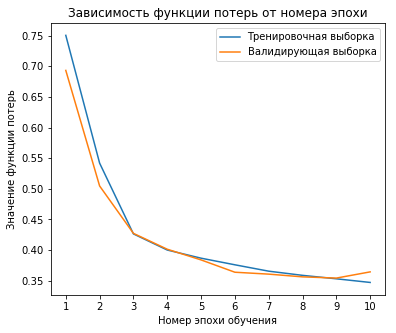

In [58]:
# Plot training & validation loss values
plt.figure(figsize=(6,5))
plt.plot(xticks, history.history['loss'])
plt.plot(xticks, history.history['val_loss'])
plt.xticks(xticks)
plt.title('Зависимость функции потерь от номера эпохи')
plt.ylabel('Значение функции потерь')
plt.xlabel('Номер эпохи обучения')
plt.legend(['Тренировочная выборка', 'Валидирующая выборка'], loc='best')
plt.show()

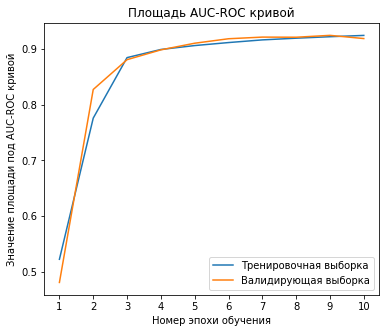

In [60]:
# Plot training & validation loss values
plt.figure(figsize=(6,5))
plt.plot(xticks, history.history['auc'])
plt.plot(xticks, history.history['val_auc'])
plt.xticks(xticks)
plt.title('Площадь AUC-ROC кривой')
plt.ylabel('Значение площади под AUC-ROC кривой')
plt.xlabel('Номер эпохи обучения')
plt.legend(['Тренировочная выборка', 'Валидирующая выборка'], loc='best')
plt.show()

In [ ]:
preds_max = [np.argmax(arr) for arr in preds]
len(preds_max)

In [ ]:
plt.hist(preds_max)

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')


In [212]:
val_acc_300d = (0.7941,0.8150,0.8441,0.8447,0.8412,0.8375,0.8443,0.8472,0.8523,0.8553,0.8546,0.8561,0.8527,0.8486,0.8545,0.8523,0.8538,0.8519,0.8489,0.8507)
val_auc_300d = (0.8208,0.8518,0.9115,0.9084,0.9125,0.9069,0.9206,0.9197,0.9265,0.9251,0.9262,0.9267,0.9252,0.9203,0.9249,0.9243,0.9211,0.9170,0.9154,0.9210)
val_time_300d = (351,311,301,300,302,302,303,302,306,305,304,304,311,307,307,308,308,307,310,308)
val_loss_300d = (0.5139,0.4713,0.3835,0.3798,0.3767,0.3889,0.3628,0.3625,0.3484,0.3499,0.3493,0.3493,0.3520,0.3658,0.3524,0.3568,0.3622,0.3818,0.3767,0.3635)

val_acc_200d = (0.6996,0.8313,0.8285,0.8266,0.8432,0.8524,0.8510,0.8466,0.8567,0.8595,0.8610,0.8568,0.8526,0.8544,0.8584,0.8578,0.8552,0.8513,0.8568,0.8571)
val_auc_200d = (0.7616,0.8887,0.8873,0.8972,0.9100,0.9198,0.9182,0.9216,0.9267,0.9284,0.9287,0.9251,0.9246,0.9227,0.9280,0.9266,0.9237,0.9200,0.9257,0.9252)
val_time_200d =(300,255,255,255,255,256,257,256,256,256,256,256,257,256,256,256,258,256,256,257)
val_loss_200d = (0.6139,0.4217,0.4221,0.4039,0.3760,0.3598,0.3629,0.3585,0.3441,0.3428,0.3392,0.3464,0.3499,0.3551,0.3411,0.3455,0.3543,0.3688,0.3467,0.3495)

val_acc_100d = (0.6028,0.7936,0.7958,0.8313,0.8303,0.8376,0.8461,0.8520,0.8469,0.8491,0.8497,0.8555,0.8506,0.8468,0.8473,0.8495,0.8491,0.8532,0.8523,0.8554)
val_auc_100d = (0.6738,0.8216,0.8419,0.8881,0.8870,0.9144,0.9176,0.9238,0.9162,0.9216,0.9237,0.9278,0.9241,0.9209,0.9195,0.9223,0.9236,0.9250,0.9241,0.9255)
val_time_100d = (246,217,214,218,213,214,216,215,218,216,216,217,216,216,215,216,218,216,216,219)
val_loss_100d = (0.7168,0.5219,0.4923,0.4191,0.4181,0.3743,0.3680,0.3546,0.3696,0.3569,0.3560,0.3426,0.3530,0.3602,0.3654,0.3570,0.3556,0.3525,0.3514,0.3494)

val_acc_50d = (0.4735,0.8003,0.8284,0.8365,0.8429,0.8432,0.8464,0.8481,0.8493,0.8492,0.8493,0.8508,0.8527,0.8478,0.8527,0.8483,0.8541,0.8538,0.8503,0.8525)
val_auc_50d = (0.4951,0.8345,0.8952,0.9082,0.9183,0.9199,0.9226,0.9223,0.9241,0.9252,0.9229,0.9249,0.9273,0.9227,0.9247,0.9238,0.9258,0.9274,0.9244,0.9269) 
val_time_50d =(245,189,208,197,197,197,197,198,197,197,198,197,197,197,196,197,197,197,202,218)
val_loss_50d =(0.6977,0.4924,0.4229,0.3904,0.3747,0.3704,0.3618,0.3570,0.3522,0.3502,0.3561,0.3586,0.3444,0.3577,0.3530,0.3576,0.3504,0.3451,0.3563,0.3498)

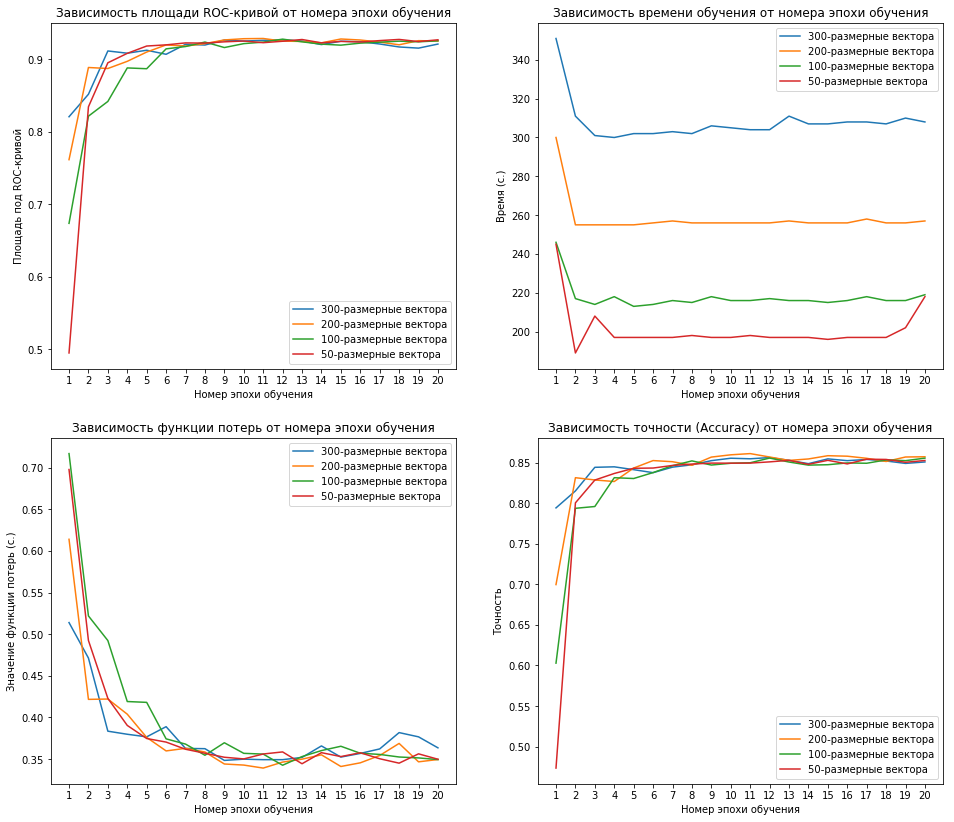

In [213]:
xticks20 = np.arange(1,21)
legendTicks = ['300-размерные вектора', '200-размерные вектора', '100-размерные вектора', '50-размерные вектора']
plt.figure(figsize=(16,14))
plt.subplot('220')
plt.plot(xticks20, val_acc_300d)
plt.plot(xticks20, val_acc_200d)
plt.plot(xticks20, val_acc_100d)
plt.plot(xticks20, val_acc_50d)
plt.xticks(xticks20)
plt.title('Зависимость точности (Accuracy) от номера эпохи обучения')
plt.ylabel('Точность')
plt.xlabel('Номер эпохи обучения')
plt.legend(legendTicks, loc='best')

plt.subplot('221')
plt.plot(xticks20, val_auc_300d)
plt.plot(xticks20, val_auc_200d)
plt.plot(xticks20, val_auc_100d)
plt.plot(xticks20, val_auc_50d)
plt.xticks(xticks20)
plt.title('Зависимость площади ROC-кривой от номера эпохи обучения')
plt.ylabel('Площадь под ROC-кривой')
plt.xlabel('Номер эпохи обучения')
plt.legend(legendTicks, loc='best')

plt.subplot('222')
plt.plot(xticks20, val_time_300d)
plt.plot(xticks20, val_time_200d)
plt.plot(xticks20, val_time_100d)
plt.plot(xticks20, val_time_50d)
plt.xticks(xticks20)
plt.title('Зависимость времени обучения от номера эпохи обучения')
plt.ylabel('Время (с.)')
plt.xlabel('Номер эпохи обучения')
plt.legend(legendTicks, loc='best')

plt.subplot('223')
plt.plot(xticks20, val_loss_300d)
plt.plot(xticks20, val_loss_200d)
plt.plot(xticks20, val_loss_100d)
plt.plot(xticks20, val_loss_50d)
plt.xticks(xticks20)
plt.title('Зависимость функции потерь от номера эпохи обучения')
plt.ylabel('Значение функции потерь (с.)')
plt.xlabel('Номер эпохи обучения')
plt.legend(legendTicks, loc='best')

plt.show()

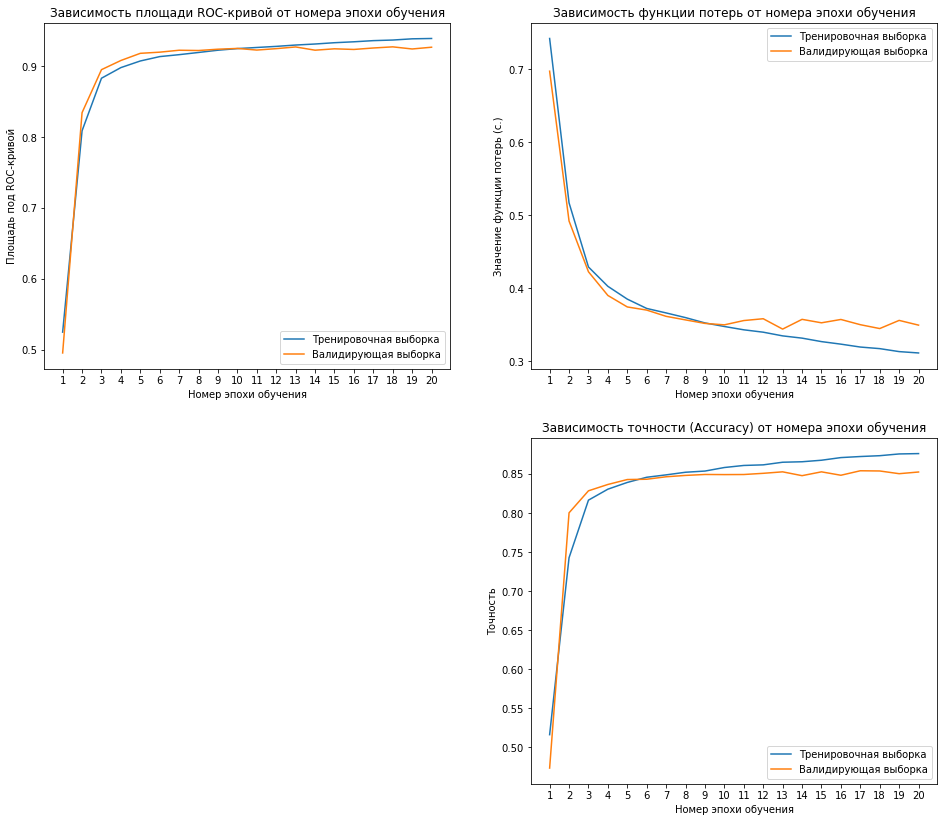

In [215]:
xticks20 = np.arange(1,21)
legendTicks = ['Тренировочная выборка', 'Валидирующая выборка']
plt.figure(figsize=(16,14))
plt.subplot('220')
plt.plot(xticks20, history.history['acc'])
plt.plot(xticks20, history.history['val_acc'])
plt.xticks(xticks20)
plt.title('Зависимость точности (Accuracy) от номера эпохи обучения')
plt.ylabel('Точность')
plt.xlabel('Номер эпохи обучения')
plt.legend(legendTicks, loc='best')

plt.subplot('221')
plt.plot(xticks20, history.history['auc'])
plt.plot(xticks20, history.history['val_auc'])
plt.xticks(xticks20)
plt.title('Зависимость площади ROC-кривой от номера эпохи обучения')
plt.ylabel('Площадь под ROC-кривой')
plt.xlabel('Номер эпохи обучения')
plt.legend(legendTicks, loc='best')

plt.subplot('222')
plt.plot(xticks20, history.history['loss'])
plt.plot(xticks20, history.history['val_loss'])
plt.xticks(xticks20)
plt.title('Зависимость функции потерь от номера эпохи обучения')
plt.ylabel('Значение функции потерь (с.)')
plt.xlabel('Номер эпохи обучения')
plt.legend(legendTicks, loc='best')

plt.show()

In [219]:
max(val_acc_50d)

0.8541

In [183]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 1000, 300)         28205400  
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 996, 128)          192128    
_________________________________________________________________
spatial_dropout1d_32 (Spatia (None, 996, 128)          0         
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 199, 128)          0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 195, 128)          82048     
_________________________________________________________________
spatial_dropout1d_33 (Spatia (None, 195, 128)          0         
__________